In [1]:
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)
warnings.filterwarnings('ignore',category=DeprecationWarning)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate, KFold, RepeatedKFold, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
import time
import cudf
from cuml.ensemble import RandomForestRegressor as cuRF
import math
import xgboost as xgb
from tqdm import tqdm

#### Output file

In [2]:
sourceFile = open("gpu_logs/porto_672.txt", 'w')

### Load the data

In [40]:
df = pd.read_pickle("../datasets/df_location.pkl")
## Leaving the first house (public building out) due to its different profile
df['Energy'] = df['Energy'].astype(np.float32)
df = df.iloc[35136:, [0, 2, 1]].reset_index(drop=True)
number_of_houses = df.Location.nunique()
num_samples_per_house = df.Location.value_counts()[1]
df.reset_index(drop=True, inplace=True)
df

,Time,Location,Energy
0,2019-01-01 00:00:00,1,2.322959
1,2019-01-01 00:15:00,1,2.371797
2,2019-01-01 00:30:00,1,2.415961
3,2019-01-01 00:45:00,1,2.302538
4,2019-01-01 01:00:00,1,2.363063
...,...,...,...
1756795,2020-01-01 22:45:00,50,0.753222
1756796,2020-01-01 23:00:00,50,0.716855
1756797,2020-01-01 23:15:00,50,0.735802
1756798,2020-01-01 23:30:00,50,0.485237


In [4]:
#trunc = lambda x: math.trunc(10000 * x) / 10000
#df_trunc = pd.DataFrame(df['Energy']).applymap(trunc)
#df = pd.concat([df.iloc[:, 0:-1], df_trunc], axis=1)
#df

### Auxiliary functions

In [5]:
def plot_results(preds: np.array, actuals: np.array, title: str):
    
    plt.scatter(actuals, preds, c='b', label='predicted')
    plt.xlabel('actual')
    plt.ylabel('predicted')
    plt.title(title)
    plt.xlim(0, plt.xlim()[1])
    plt.ylim(0, plt.ylim()[1])
    _ = plt.plot([0, 100], [0, 100], '--r', label='y=x')
    plt.legend()
    plt.show()

def truncate_metric(metric):
    m = math.trunc(10000 * metric) / 10000
    return m 
    
def performance_metrics(preds: np.array, actuals: np.array, filename):

    # calculate performance metrics
    
    mse = truncate_metric(mean_squared_error(actuals, preds))
    wape = truncate_metric(np.sum(np.abs(preds - actuals)) / np.sum(np.abs(actuals))) * 100
    r2 = truncate_metric(r2_score(actuals, preds))
    
    # print performance metrics
    print('MSE: %.4f' % mse, file=filename)
    print('WAPE: %.2f' % wape, file=filename)
    print('R2: %.4f' % r2, file=filename)
    return mse, wape, r2

#@jit(target_backend='cuda')
def build_model(estimator, X_train: np.array, y_train: np.array, X_test: np.array):
    
    model = estimator
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    
    return model, preds

def validate(estimator, X_train, y_train):
    scores = cross_validate(estimator, X_train, y_train, scoring=['r2', 'neg_mean_squared_error'])
    return scores
    

In [6]:
def total_averaged_metrics(metrics_list, filename):
    
    print("Total Averaged MSE: {}".format(np.round(sum(i for i, j, k in metrics_list)/len(metrics_list),3)), file=filename)
    print("Total Averaged WAPE: {}".format(np.round(sum(j for i, j, k in metrics_list)/len(metrics_list),3)), file=filename)
    print("Total Averaged R2: {}".format(np.round(sum(k for i, j, k in metrics_list)/len(metrics_list),3)), file=filename)

def past_timesteps(df, number_of_timesteps):
    df = df.sort_values(by=['Location', 'Time'])
    for i in tqdm(range(1, (number_of_timesteps + 1))):
        df.loc[df['Time'].shift(i) == df['Time'] - pd.Timedelta(i * 15, 'm'), f"energy_lag_{i}"] = df['Energy'].shift(i)
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

#def past_timesteps(df, number_of_timesteps):
#    # Sort the dataframe by location and time
#    df = df.sort_values(by=['Location', 'Time'])
#
#    # Compute rolling window over time axis to extract past energy values for each location
#    energy_lags = [f"energy_lag_{i}" for i in range(1, number_of_timesteps+1)]
#    past_energy = df.groupby('Location')['Energy'].rolling(window=number_of_timesteps, min_periods=1).apply(np.mean())
#    # Add new columns to the dataframe for each past energy value
#    for i, energy_lag in enumerate(energy_lags):
#        df[energy_lag] = past_energy.apply(lambda x: x[-i-1] if isinstance(x, list) and len(x)>=i+1 else x)
#
#    # Drop rows with missing values
#    df.dropna(inplace=True)
#    df.reset_index(drop=True, inplace=True)
#
#    return df


def last_energy_points_full(df, number_timesteps, num_samples_per_house):
    X = pd.DataFrame()
    other_feats = df.iloc[:,:2]
    for i in range(1, (number_timesteps + 1) ):
        X[f'Energy_{i*15}'] = df['Energy'].shift(i)
    y = df.copy().iloc[:,2]
    y.iloc[:number_timesteps] = np.nan
    ## Remove samples in between each house
    for h in range(1, number_of_houses):
        for i in range(0, number_timesteps):
            X.iloc[(num_samples_per_house+i)*h] = np.nan
            y.iloc[(num_samples_per_house+i)*h] = np.nan
    X = pd.concat([other_feats, X], axis=1)
    X.dropna(inplace=True)
    X.reset_index(drop=True, inplace=True)
    y.dropna(inplace=True)
    y.reset_index(drop=True, inplace=True)
    y.columns = ["Energy"]
    dataframe = pd.concat([X,y.rename('Energy')], axis=1)
    assert number_of_houses == (df.shape[0] - dataframe.shape[0]) / number_timesteps, "Something went wrong with preprocessing"
    return dataframe
    

In [7]:
def normalize_training(X_train):
    scaler = MinMaxScaler(feature_range=(0,1))
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    return X_train, scaler

In [8]:
def test_leave_house_out(df, estimator, locations, filename):
    test = df[df['Location'].isin(locations)]
    train = df[~df['Location'].isin(locations)]
    print("Train set: ", train.shape)
    print("Test set: ", test.shape)
    X_train = train.drop(['Time', 'Energy', 'Location'], axis=1)
    X_test = test.drop(['Time', 'Energy', 'Location'], axis=1)
    y_train = train['Energy']
    y_test = test['Energy']

    X_train_norm, scaler = normalize_training(X_train)
    X_test_norm = scaler.transform(X_test)
    model = estimator
    init = time.time()
    model.fit(X_train_norm, y_train)
    y_pred = model.predict(X_test_norm)
    end = time.time()
    print('Elapsed time: {:.4f} s'.format(end - init), file=filename)
    mse, wape, r2 = performance_metrics(y_pred, y_test.values.reshape(-1), filename)
    return mse, wape, r2, model

## Save Dataframe with past timesteps

In [43]:
number_of_timesteps = 672

In [44]:
df_new = past_timesteps(df, number_of_timesteps)
df_new

 14%|█▍        | 94/672 [00:02<00:13, 41.90it/s]/tmp/ipykernel_1485892/3197527601.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[df['Time'].shift(i) == df['Time'] - pd.Timedelta(i * 15, 'm'), f"energy_lag_{i}"] = df['Energy'].shift(i)
/tmp/ipykernel_1485892/3197527601.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[df['Time'].shift(i) == df['Time'] - pd.Timedelta(i * 15, 'm'), f"energy_lag_{i}"] = df['Energy'].shift(i)
 15%|█▍        | 99/672 [00:02<00:13, 42.55it/s]/tmp/ipykernel_1485892/3197527601.py:1

,Time,Location,Energy,energy_lag_1,energy_lag_2,energy_lag_3,energy_lag_4,energy_lag_5,energy_lag_6,energy_lag_7,...,energy_lag_663,energy_lag_664,energy_lag_665,energy_lag_666,energy_lag_667,energy_lag_668,energy_lag_669,energy_lag_670,energy_lag_671,energy_lag_672
0,2019-01-08 00:00:00,1,1.243963,1.362799,1.311378,1.251099,1.477207,1.758796,1.550280,1.795948,...,2.402921,2.341043,2.316070,2.299586,2.334031,2.363063,2.302538,2.415961,2.371797,2.322959
1,2019-01-08 00:15:00,1,1.289234,1.243963,1.362799,1.311378,1.251099,1.477207,1.758796,1.550280,...,2.342396,2.402921,2.341043,2.316070,2.299586,2.334031,2.363063,2.302538,2.415961,2.371797
2,2019-01-08 00:30:00,1,1.253928,1.289234,1.243963,1.362799,1.311378,1.251099,1.477207,1.758796,...,2.443886,2.342396,2.402921,2.341043,2.316070,2.299586,2.334031,2.363063,2.302538,2.415961
3,2019-01-08 00:45:00,1,1.233753,1.253928,1.289234,1.243963,1.362799,1.311378,1.251099,1.477207,...,2.406489,2.443886,2.342396,2.402921,2.341043,2.316070,2.299586,2.334031,2.363063,2.302538
4,2019-01-08 01:00:00,1,1.287758,1.233753,1.253928,1.289234,1.243963,1.362799,1.311378,1.251099,...,2.378686,2.406489,2.443886,2.342396,2.402921,2.341043,2.316070,2.299586,2.334031,2.363063
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1723195,2020-01-01 22:45:00,50,0.753222,1.099100,0.453906,0.481770,0.483173,0.467528,1.001887,0.552398,...,0.676236,1.194125,2.010091,1.710115,1.515525,2.055415,2.535657,1.772033,1.482914,1.723943
1723196,2020-01-01 23:00:00,50,0.716855,0.753222,1.099100,0.453906,0.481770,0.483173,0.467528,1.001887,...,0.642552,0.676236,1.194125,2.010091,1.710115,1.515525,2.055415,2.535657,1.772033,1.482914
1723197,2020-01-01 23:15:00,50,0.735802,0.716855,0.753222,1.099100,0.453906,0.481770,0.483173,0.467528,...,0.697247,0.642552,0.676236,1.194125,2.010091,1.710115,1.515525,2.055415,2.535657,1.772033
1723198,2020-01-01 23:30:00,50,0.485237,0.735802,0.716855,0.753222,1.099100,0.453906,0.481770,0.483173,...,0.780631,0.697247,0.642552,0.676236,1.194125,2.010091,1.710115,1.515525,2.055415,2.535657


In [ ]:
df_new['DayOfWeek'] = df_new['Time'].dt.dayofweek
df_new['Weekend'] = df_new['Time'].dt.dayofweek.isin([5, 6]).astype(int)
df_new['Hour'] = df_new['Time'].dt.hour
df_new

In [ ]:
df_new.to_csv("data/porto_oneweek.csv", index=False)

## Predict  10 folds with 10 random houses for test

In [54]:
df_test = pd.read_csv("data/porto_oneweek.csv", nrows=100)

float_cols = [c for c in df_test if df_test[c].dtype == "float64"]
float32_cols = {c: np.float32 for c in float_cols}

df = pd.read_csv("data/porto_oneweek.csv", engine='c', dtype=float32_cols)
df

: 

: 

In [ ]:
type(df['energy_lag_1'][0])

In [48]:
df = pd.read_csv("data/porto_oneweek.csv")

df

,Time,Location,Energy,energy_lag_1,energy_lag_2,energy_lag_3,energy_lag_4,energy_lag_5,energy_lag_6,energy_lag_7,...,energy_lag_666,energy_lag_667,energy_lag_668,energy_lag_669,energy_lag_670,energy_lag_671,energy_lag_672,DayOfWeek,Weekend,Hour
0,2019-01-08 00:00:00,1,1.243963,1.362799,1.311378,1.251098,1.477207,1.758796,1.550280,1.795948,...,2.299586,2.334031,2.363063,2.302538,2.415961,2.371797,2.322959,1,0,0
1,2019-01-08 00:15:00,1,1.289234,1.243963,1.362799,1.311378,1.251098,1.477207,1.758796,1.550280,...,2.316070,2.299586,2.334031,2.363063,2.302538,2.415961,2.371797,1,0,0
2,2019-01-08 00:30:00,1,1.253928,1.289234,1.243963,1.362799,1.311378,1.251098,1.477207,1.758796,...,2.341043,2.316070,2.299586,2.334031,2.363063,2.302538,2.415961,1,0,0
3,2019-01-08 00:45:00,1,1.233753,1.253928,1.289234,1.243963,1.362799,1.311378,1.251098,1.477207,...,2.402921,2.341043,2.316070,2.299586,2.334031,2.363063,2.302538,1,0,0
4,2019-01-08 01:00:00,1,1.287758,1.233753,1.253928,1.289234,1.243963,1.362799,1.311378,1.251098,...,2.342396,2.402921,2.341043,2.316070,2.299586,2.334031,2.363063,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1723195,2020-01-01 22:45:00,50,0.753221,1.099100,0.453906,0.481770,0.483173,0.467528,1.001887,0.552398,...,1.710115,1.515524,2.055415,2.535657,1.772034,1.482914,1.723943,2,0,22
1723196,2020-01-01 23:00:00,50,0.716855,0.753221,1.099100,0.453906,0.481770,0.483173,0.467528,1.001887,...,2.010091,1.710115,1.515524,2.055415,2.535657,1.772034,1.482914,2,0,23
1723197,2020-01-01 23:15:00,50,0.735802,0.716855,0.753221,1.099100,0.453906,0.481770,0.483173,0.467528,...,1.194125,2.010091,1.710115,1.515524,2.055415,2.535657,1.772034,2,0,23
1723198,2020-01-01 23:30:00,50,0.485237,0.735802,0.716855,0.753221,1.099100,0.453906,0.481770,0.483173,...,0.676236,1.194125,2.010091,1.710115,1.515524,2.055415,2.535657,2,0,23


In [50]:
type(df['energy_lag_1'][0])

numpy.float64

In [10]:
df.isna().sum().sum()

0

In [11]:
#num_houses_test = 10

In [12]:
kf = RepeatedKFold(n_splits=5, n_repeats=2, random_state=42) 
locations = []
for _, test_index in kf.split(df['Location'].unique()):
    locations.append(test_index)
locations

[array([13, 17, 19, 25, 26, 30, 32, 39, 45, 48]),
 array([ 3,  4,  6,  8, 12, 15, 37, 41, 46, 47]),
 array([ 0,  5,  9, 16, 24, 27, 31, 33, 34, 44]),
 array([ 1,  2, 11, 21, 23, 29, 35, 36, 40, 43]),
 array([ 7, 10, 14, 18, 20, 22, 28, 38, 42, 49]),
 array([ 0,  2, 10, 22, 29, 38, 39, 44, 45, 46]),
 array([ 4, 12, 18, 21, 24, 30, 31, 32, 33, 49]),
 array([ 9, 14, 15, 20, 23, 26, 36, 40, 41, 42]),
 array([ 3,  5, 11, 16, 17, 28, 35, 37, 47, 48]),
 array([ 1,  6,  7,  8, 13, 19, 25, 27, 34, 43])]

In [13]:
df.Location.value_counts()

1     34464
38    34464
28    34464
29    34464
30    34464
31    34464
32    34464
33    34464
34    34464
35    34464
36    34464
37    34464
39    34464
2     34464
40    34464
41    34464
42    34464
43    34464
44    34464
45    34464
46    34464
47    34464
48    34464
49    34464
27    34464
26    34464
25    34464
24    34464
3     34464
4     34464
5     34464
6     34464
7     34464
8     34464
9     34464
10    34464
11    34464
12    34464
13    34464
14    34464
15    34464
16    34464
17    34464
18    34464
19    34464
20    34464
21    34464
22    34464
23    34464
50    34464
Name: Location, dtype: int64

### Linear Regression

In [ ]:
metrics_list_lr = []
print("\n----------------------------", file=sourceFile)
print("\nLinear Regression\n", file=sourceFile)
print("----------------------------\n", file=sourceFile)
for i in range(1):
    print("\nIteration", i, file=sourceFile)
    print("\nIteration", i)
    mse, wape, r2, model_lr = test_leave_house_out(df, LinearRegression(), locations[i], sourceFile)
    metrics_list_lr.append((mse, wape, r2))

### XGBoost

In [14]:
metrics_list_xgb = []
print("\n----------------------------", file=sourceFile)
print("\nXGBoost\n", file=sourceFile)
print("----------------------------\n", file=sourceFile)
for i in range(2):
    print("\nIteration", i, file=sourceFile)
    print("\nIteration", i)
    mse, wape, r2, model_xgb = test_leave_house_out(df, xgb.XGBRegressor(tree_method='gpu_hist', seed=0), locations[i], sourceFile)
    metrics_list_xgb.append((mse, wape, r2))


Iteration 0
Train set:  (1378560, 678)
Test set:  (344640, 678)

Iteration 1
Train set:  (1378560, 678)
Test set:  (344640, 678)


### Random Forest

In [ ]:
metrics_list_rf = []
print("\n----------------------------", file=sourceFile)
print("\nRandom Forest\n", file=sourceFile)
print("----------------------------\n", file=sourceFile)
for i in range(5):
    print("\nIteration", i, file=sourceFile)
    print("\nIteration", i)
    mse, wape, r2, model_rf = test_leave_house_out(df, cuRF(), locations[i], sourceFile)
    metrics_list_rf.append((mse, wape, r2))

## Averaged Metrics

In [15]:
print("\n\n\n", file=sourceFile)

In [ ]:
print("\nLinear Regression", file=sourceFile)
total_averaged_metrics(metrics_list_lr, sourceFile)

In [16]:
print("\nXGBoost", file=sourceFile)
total_averaged_metrics(metrics_list_xgb, sourceFile)

In [ ]:
print("\nRandom Forest", file=sourceFile)
total_averaged_metrics(metrics_list_rf, sourceFile)

In [17]:
sourceFile.close()

### Feature Importance

In [ ]:
print('Linear Regression\n')
for i,v in enumerate(model_lr.coef_):
    print('Feature: %0d, Score: %.5f' % (i,v))
print('XGBoost\n')
for i,v in enumerate(model_xgb.feature_importances_):
    print('Feature: %0d, Score: %.5f' % (i,v))

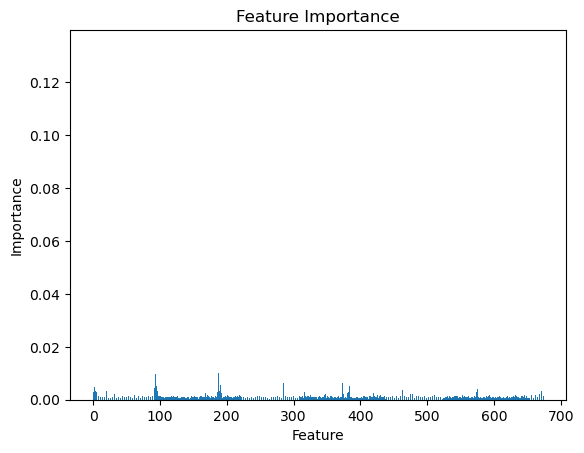

In [22]:
plt.bar(range(len(model_xgb.feature_importances_)),model_xgb.feature_importances_)
plt.title('Feature Importance')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()

In [ ]:
plt.bar(range(len(model_lr.coef_)),model_lr.coef_)
plt.title('Feature Importance')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()

In [19]:
columns = df.drop(["Energy", "Location", "Time"], axis=1).columns
feature_importance = pd.Series(model_xgb.feature_importances_, index=columns)
feature_importance

energy_lag_1      0.133153
energy_lag_2      0.003085
energy_lag_3      0.004827
energy_lag_4      0.001065
energy_lag_5      0.003485
                    ...   
energy_lag_671    0.008658
energy_lag_672    0.003448
DayOfWeek         0.000849
Weekend           0.000000
Hour              0.001350
Length: 675, dtype: float32

In [20]:
features = feature_importance.nlargest(40).index
features

Index(['energy_lag_1', 'energy_lag_189', 'energy_lag_94', 'energy_lag_671',
       'energy_lag_374', 'energy_lag_286', 'energy_lag_191', 'energy_lag_192',
       'energy_lag_95', 'energy_lag_91', 'energy_lag_385', 'energy_lag_96',
       'energy_lag_659', 'energy_lag_188', 'energy_lag_3', 'energy_lag_287',
       'energy_lag_93', 'energy_lag_284', 'energy_lag_576', 'energy_lag_574',
       'energy_lag_464', 'energy_lag_378', 'energy_lag_5', 'energy_lag_21',
       'energy_lag_672', 'energy_lag_97', 'energy_lag_190', 'energy_lag_2',
       'energy_lag_317', 'energy_lag_89', 'energy_lag_383', 'energy_lag_92',
       'energy_lag_6', 'energy_lag_575', 'energy_lag_187', 'energy_lag_510',
       'energy_lag_35', 'energy_lag_382', 'energy_lag_421', 'energy_lag_278'],
      dtype='object')

In [29]:
df_40 = df[['Time', 'Location'] + [*features] + ['Energy']]
df_40

,Time,Location,energy_lag_1,energy_lag_189,energy_lag_94,energy_lag_671,energy_lag_374,energy_lag_286,energy_lag_191,energy_lag_192,...,energy_lag_92,energy_lag_6,energy_lag_575,energy_lag_187,energy_lag_510,energy_lag_35,energy_lag_382,energy_lag_421,energy_lag_278,Energy
0,2019-01-08 00:00:00,1,1.362799,1.218622,0.517908,2.371797,2.192682,1.992285,1.430336,1.556923,...,0.254402,1.550280,0.372131,0.264859,1.379530,4.177094,4.270957,0.327352,2.245580,1.243963
1,2019-01-08 00:15:00,1,1.243963,0.792239,0.245668,2.415961,2.189238,2.743436,1.304366,1.430336,...,0.334733,1.758796,0.521968,0.262522,1.848600,3.261713,2.589786,0.240993,2.198833,1.289234
2,2019-01-08 00:30:00,1,1.289234,0.264859,0.254402,2.302538,2.211135,2.213350,1.218622,1.304366,...,0.227215,1.477207,0.407560,0.280113,2.213350,2.329233,2.268585,0.310991,2.200679,1.253928
3,2019-01-08 00:45:00,1,1.253928,0.262522,0.334733,2.363063,2.174599,2.281748,0.792239,1.218622,...,0.277653,1.251098,0.414080,0.266335,2.057239,1.959439,4.028980,0.304102,2.288268,1.233753
4,2019-01-08 01:00:00,1,1.233753,0.280113,0.227215,2.334031,2.145074,2.159591,0.264859,0.792239,...,0.368441,1.311378,0.413834,0.300288,1.650909,2.221223,2.137939,0.258462,2.217286,1.287758
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1723195,2020-01-01 22:45:00,50,1.099100,0.803087,0.935428,1.482914,1.026614,0.735802,0.931837,0.778195,...,1.077717,1.001887,0.716855,0.821869,0.294279,0.375228,0.935428,0.426166,1.285599,0.753221
1723196,2020-01-01 23:00:00,50,0.753221,0.600777,0.715781,1.772034,0.848700,0.485237,0.937079,0.931837,...,0.881889,0.467528,0.735802,0.997264,0.297623,0.321565,0.715781,0.190916,1.459798,0.716855
1723197,2020-01-01 23:15:00,50,0.716855,0.821869,1.077717,2.535657,1.156395,0.394216,0.803087,0.937079,...,0.858855,0.483173,0.485237,1.210760,0.563833,0.414113,1.077717,0.105345,1.744294,0.735802
1723198,2020-01-01 23:30:00,50,0.735802,0.997264,0.881889,2.055415,1.029379,0.429262,0.600777,0.803087,...,1.082588,0.481770,0.394216,1.707349,0.517930,0.297128,0.881889,0.091144,1.680559,0.485237


In [23]:
df_40.to_csv("data/porto_best40features.csv", index=False)

### Test with 40 best features

In [24]:
sourceFile = open("gpu_logs/ensemble_porto_40best.txt", 'w')

In [25]:
df_40 = pd.read_csv("data/porto_best40features.csv")
df_40

,Time,Location,energy_lag_1,energy_lag_189,energy_lag_94,energy_lag_671,energy_lag_374,energy_lag_286,energy_lag_191,energy_lag_192,...,energy_lag_92,energy_lag_6,energy_lag_575,energy_lag_187,energy_lag_510,energy_lag_35,energy_lag_382,energy_lag_421,energy_lag_278,Energy
0,2019-01-08 00:00:00,1,1.362799,1.218622,0.517908,2.371797,2.192682,1.992285,1.430336,1.556923,...,0.254402,1.550280,0.372131,0.264859,1.379530,4.177094,4.270957,0.327352,2.245580,1.243963
1,2019-01-08 00:15:00,1,1.243963,0.792239,0.245668,2.415961,2.189238,2.743436,1.304366,1.430336,...,0.334733,1.758796,0.521968,0.262522,1.848600,3.261713,2.589786,0.240993,2.198833,1.289234
2,2019-01-08 00:30:00,1,1.289234,0.264859,0.254402,2.302538,2.211135,2.213350,1.218622,1.304366,...,0.227215,1.477207,0.407560,0.280113,2.213350,2.329233,2.268585,0.310991,2.200679,1.253928
3,2019-01-08 00:45:00,1,1.253928,0.262522,0.334733,2.363063,2.174599,2.281748,0.792239,1.218622,...,0.277653,1.251098,0.414080,0.266335,2.057239,1.959439,4.028980,0.304102,2.288268,1.233753
4,2019-01-08 01:00:00,1,1.233753,0.280113,0.227215,2.334031,2.145074,2.159591,0.264859,0.792239,...,0.368441,1.311378,0.413834,0.300288,1.650909,2.221223,2.137939,0.258462,2.217286,1.287758
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1723195,2020-01-01 22:45:00,50,1.099100,0.803087,0.935428,1.482914,1.026614,0.735802,0.931837,0.778195,...,1.077717,1.001887,0.716855,0.821869,0.294279,0.375228,0.935428,0.426166,1.285599,0.753221
1723196,2020-01-01 23:00:00,50,0.753221,0.600777,0.715781,1.772034,0.848700,0.485237,0.937079,0.931837,...,0.881889,0.467528,0.735802,0.997264,0.297623,0.321565,0.715781,0.190916,1.459798,0.716855
1723197,2020-01-01 23:15:00,50,0.716855,0.821869,1.077717,2.535657,1.156395,0.394216,0.803087,0.937079,...,0.858855,0.483173,0.485237,1.210760,0.563833,0.414113,1.077717,0.105345,1.744294,0.735802
1723198,2020-01-01 23:30:00,50,0.735802,0.997264,0.881889,2.055415,1.029379,0.429262,0.600777,0.803087,...,1.082588,0.481770,0.394216,1.707349,0.517930,0.297128,0.881889,0.091144,1.680559,0.485237


In [26]:
metrics_list_lr = []
print("\n----------------------------", file=sourceFile)
print("\nLinear Regression\n", file=sourceFile)
print("----------------------------\n", file=sourceFile)
for i in range(10):
    print("\nIteration", i, file=sourceFile)
    print("\nIteration", i)
    mse, wape, r2, model_lr = test_leave_house_out(df_40, LinearRegression(), locations[i], sourceFile)
    metrics_list_lr.append((mse, wape, r2))


Iteration 0
Train set:  (1378560, 43)
Test set:  (344640, 43)

Iteration 1
Train set:  (1378560, 43)
Test set:  (344640, 43)

Iteration 2
Train set:  (1413024, 43)
Test set:  (310176, 43)

Iteration 3
Train set:  (1378560, 43)
Test set:  (344640, 43)

Iteration 4
Train set:  (1378560, 43)
Test set:  (344640, 43)

Iteration 5
Train set:  (1413024, 43)
Test set:  (310176, 43)

Iteration 6
Train set:  (1378560, 43)
Test set:  (344640, 43)

Iteration 7
Train set:  (1378560, 43)
Test set:  (344640, 43)

Iteration 8
Train set:  (1378560, 43)
Test set:  (344640, 43)

Iteration 9
Train set:  (1378560, 43)
Test set:  (344640, 43)


In [27]:
metrics_list_xgb = []
print("\n----------------------------", file=sourceFile)
print("\nXGBoost\n", file=sourceFile)
print("----------------------------\n", file=sourceFile)
for i in range(10):
    print("\nIteration", i, file=sourceFile)
    print("\nIteration", i)
    mse, wape, r2, model_xgb = test_leave_house_out(df_40, xgb.XGBRegressor(tree_method='gpu_hist', seed=0), locations[i], sourceFile)
    metrics_list_xgb.append((mse, wape, r2))


Iteration 0
Train set:  (1378560, 43)
Test set:  (344640, 43)

Iteration 1
Train set:  (1378560, 43)
Test set:  (344640, 43)

Iteration 2
Train set:  (1413024, 43)
Test set:  (310176, 43)

Iteration 3
Train set:  (1378560, 43)
Test set:  (344640, 43)

Iteration 4
Train set:  (1378560, 43)
Test set:  (344640, 43)

Iteration 5
Train set:  (1413024, 43)
Test set:  (310176, 43)

Iteration 6
Train set:  (1378560, 43)
Test set:  (344640, 43)

Iteration 7
Train set:  (1378560, 43)
Test set:  (344640, 43)

Iteration 8
Train set:  (1378560, 43)
Test set:  (344640, 43)

Iteration 9
Train set:  (1378560, 43)
Test set:  (344640, 43)


In [33]:
metrics_list_rf = []
print("\n----------------------------", file=sourceFile)
print("\nRandom Forest\n", file=sourceFile)
print("----------------------------\n", file=sourceFile)
for i in range(10):
    print("\nIteration", i, file=sourceFile)
    print("\nIteration", i)
    mse, wape, r2, model_rf = test_leave_house_out(df_40, cuRF(), locations[i], sourceFile)
    metrics_list_rf.append((mse, wape, r2))


Iteration 0
Train set:  (1378560, 43)
Test set:  (344640, 43)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)



Iteration 1
Train set:  (1378560, 43)
Test set:  (344640, 43)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)



Iteration 2
Train set:  (1413024, 43)
Test set:  (310176, 43)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)



Iteration 3
Train set:  (1378560, 43)
Test set:  (344640, 43)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)



Iteration 4
Train set:  (1378560, 43)
Test set:  (344640, 43)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)



Iteration 5
Train set:  (1413024, 43)
Test set:  (310176, 43)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)



Iteration 6
Train set:  (1378560, 43)
Test set:  (344640, 43)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)



Iteration 7
Train set:  (1378560, 43)
Test set:  (344640, 43)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)



Iteration 8
Train set:  (1378560, 43)
Test set:  (344640, 43)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)



Iteration 9
Train set:  (1378560, 43)
Test set:  (344640, 43)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


In [34]:
print("\n\n\n", file=sourceFile)

In [35]:
print("\nLinear Regression", file=sourceFile)
total_averaged_metrics(metrics_list_lr, sourceFile)

In [36]:
print("\nXGBoost", file=sourceFile)
total_averaged_metrics(metrics_list_xgb, sourceFile)

In [37]:
print("\nRandom Forest", file=sourceFile)
total_averaged_metrics(metrics_list_rf, sourceFile)

In [38]:
sourceFile.close()